In [ ]:
## Step 1 - Import the Libraries
import numpy as np
import pandas as pd
# import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
# import matplotlib
# import matplotlib.dates as mdates
import ta  # Technical Analysis library

In [9]:
## Step 2 – Reading our training data and getting our training data in shape
def load_stock_data(ticker, start_date, end_date):
    """Load stock data from Yahoo Finance."""
    ticker = ticker.replace('.', '-')
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)  # Ensure 'Date' is a column, not the index
    return data

def feature_engineering(data):
    # Calculate MACD
    data['macd'] = ta.trend.macd(data['Adj Close'])
    
    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Adj Close'])
    data['boll_ub'] = bollinger.bollinger_hband()
    data['boll_lb'] = bollinger.bollinger_lband()
    
    # Calculate RSI with a window size of 30
    rsi_window = 30
    data[f'rsi_{rsi_window}'] = ta.momentum.RSIIndicator(data['Adj Close'], window=rsi_window).rsi()
    
    # Calculate ADX with a window size of 30
    adx_window = 30
    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Adj Close'], window=adx_window)
    data[f'dx_{adx_window}'] = adx.adx()
    
    # Calculate SMA
    data['close_30_sma'] = data['Adj Close'].rolling(window=30).mean()
    data['close_60_sma'] = data['Adj Close'].rolling(window=60).mean()
    
    # Drop rows with NaN values after feature creation
    data.dropna(inplace=True)
    
    return data

def get_sp500_tickers():
    """Fetch the list of S&P 500 tickers from Wikipedia."""
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]  # Index might vary; adjust if necessary
    tickers = sp500_table['Symbol'].tolist()
    return tickers

# Fetch the list of Dow 30 tickers
sp500_tickers = get_sp500_tickers()

# Define the training time frame
start_date = "2024-01-01"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

# Initialize a list to collect the dataframes
all_data = []

for ticker in sp500_tickers:
    # Load data for each ticker
    data = load_stock_data(ticker, start_date, end_date)
    
    # Feature engineering
    data = feature_engineering(data)
    
    # Add a column for ticker to identify the stock later
    data['Ticker'] = ticker
    
    # Append to the list
    all_data.append(data)

# Concatenate all the dataframes into one
dataset_train = pd.concat(all_data)
dataset_train['inc_dec'] = np.where(dataset_train['Volume'].shift(-1) > dataset_train['Volume'], 1, 0)
dataset_train['returns'] = dataset_train['Adj Close'].pct_change()

# Print the shape of DataFrame and check for null values
print("Dataframe Shape: ", dataset_train.shape)
print("Null Value Present: ", dataset_train.isnull().values.any())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

IndexError: index 15 is out of bounds for axis 0 with size 13

In [4]:
dataset_train

NameError: name 'dataset_train' is not defined

In [58]:
# labelencoder = LabelEncoder()

# dataset_train['Ticker'] = labelencoder.fit_transform(dataset_train['Ticker'])

# dataset_train.shape

(72399, 17)

## Regression

In [59]:
X = dataset_train.drop(columns=['Adj Close', 'Date', 'Ticker']).fillna(0)
Y = dataset_train['Adj Close']
X

,Open,High,Low,Close,Volume,macd,boll_ub,boll_lb,rsi_30,dx_30,close_30_sma,close_60_sma,Ticker,inc_dec,returns
59,111.688965,112.851173,111.354515,112.207359,2280174,0.196930,80.017001,77.366416,52.442578,27.299190,78.639631,78.497641,20,1,0.000000
60,112.550163,113.603676,112.525085,113.428093,3243313,0.311512,80.310157,77.277795,55.011585,26.739169,78.709589,78.482144,20,0,0.010879
61,113.612038,114.255852,113.436455,114.155518,2835477,0.438885,80.687994,77.128212,56.461579,26.088087,78.803066,78.472102,20,1,0.006414
62,113.704010,113.921402,113.152176,113.712372,3924554,0.508609,80.896622,77.047053,55.337606,25.499708,78.910574,78.464874,20,0,-0.003882
63,113.896324,114.707359,113.461540,113.829430,3200735,0.564060,81.092560,76.973244,55.579180,24.798916,79.001084,78.458832,20,1,0.001029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,51.816666,52.383331,51.720001,52.216667,19405500,-0.319304,52.238774,49.776828,49.341276,13.616418,51.646542,52.429363,29,0,0.011951
2512,52.216667,52.330002,52.036667,52.136665,11679900,-0.243216,52.251080,49.771808,49.037734,13.276956,51.545403,52.413206,29,1,-0.001532
2513,52.103333,52.650002,52.053333,52.626667,19896000,-0.142009,52.236280,49.780881,50.949643,12.843049,51.444106,52.404226,29,0,0.009398
2514,52.590000,52.776669,52.500000,52.523335,16776000,-0.069285,52.356325,49.729283,50.536042,12.447747,51.339717,52.399087,29,1,-0.001964


In [62]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state=0, n_jobs=-1)
model = clf.fit(X, Y)

importances = model.feature_importances_

<function matplotlib.pyplot.show(close=None, block=None)>

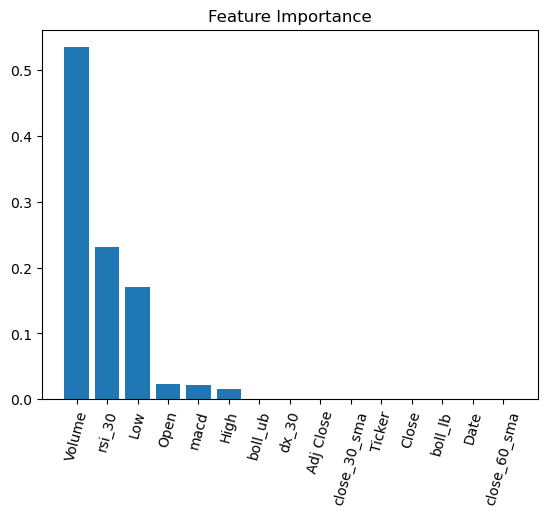

In [64]:
%matplotlib inline

indices = np.argsort(importances)[::-1]
names = [dataset_train.columns[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=75)

plt.show

## Classification

In [65]:
X = dataset_train.drop(columns=['inc_dec', 'Date']).fillna(0)
Y = dataset_train['inc_dec']

In [ ]:
clf = RandomForestRegressor(random_state=0, n_jobs=-1)
model = clf.fit(X, Y)

importances = model.feature_importances_

<function matplotlib.pyplot.show(close=None, block=None)>

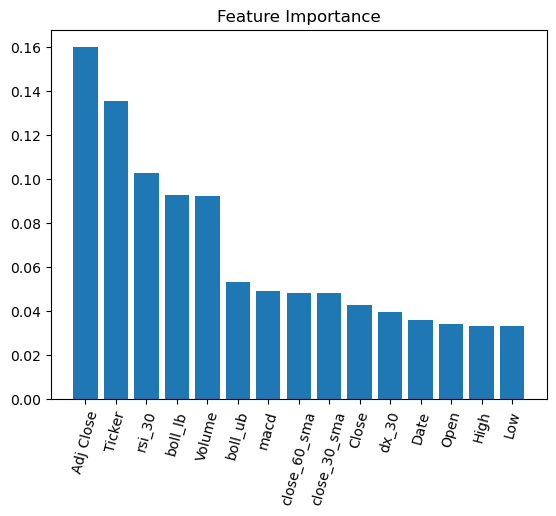

In [67]:
%matplotlib inline

indices = np.argsort(importances)[::-1]
names = [dataset_train.columns[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=75)

plt.show